In [26]:
import pandas as pd
import numpy as np
import os
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

In [27]:
os.getcwd()

'/workspaces/Problem_set2_BDML'

In [28]:
casas = pd.read_csv('/workspaces/Problem_set2_BDML/stores/base_datos_tratada.csv')

Intentaremos hacer un modelo de k-vecinos para solucionar el problema de missing values en variables importantes para nuestro estudio

<Axes: >

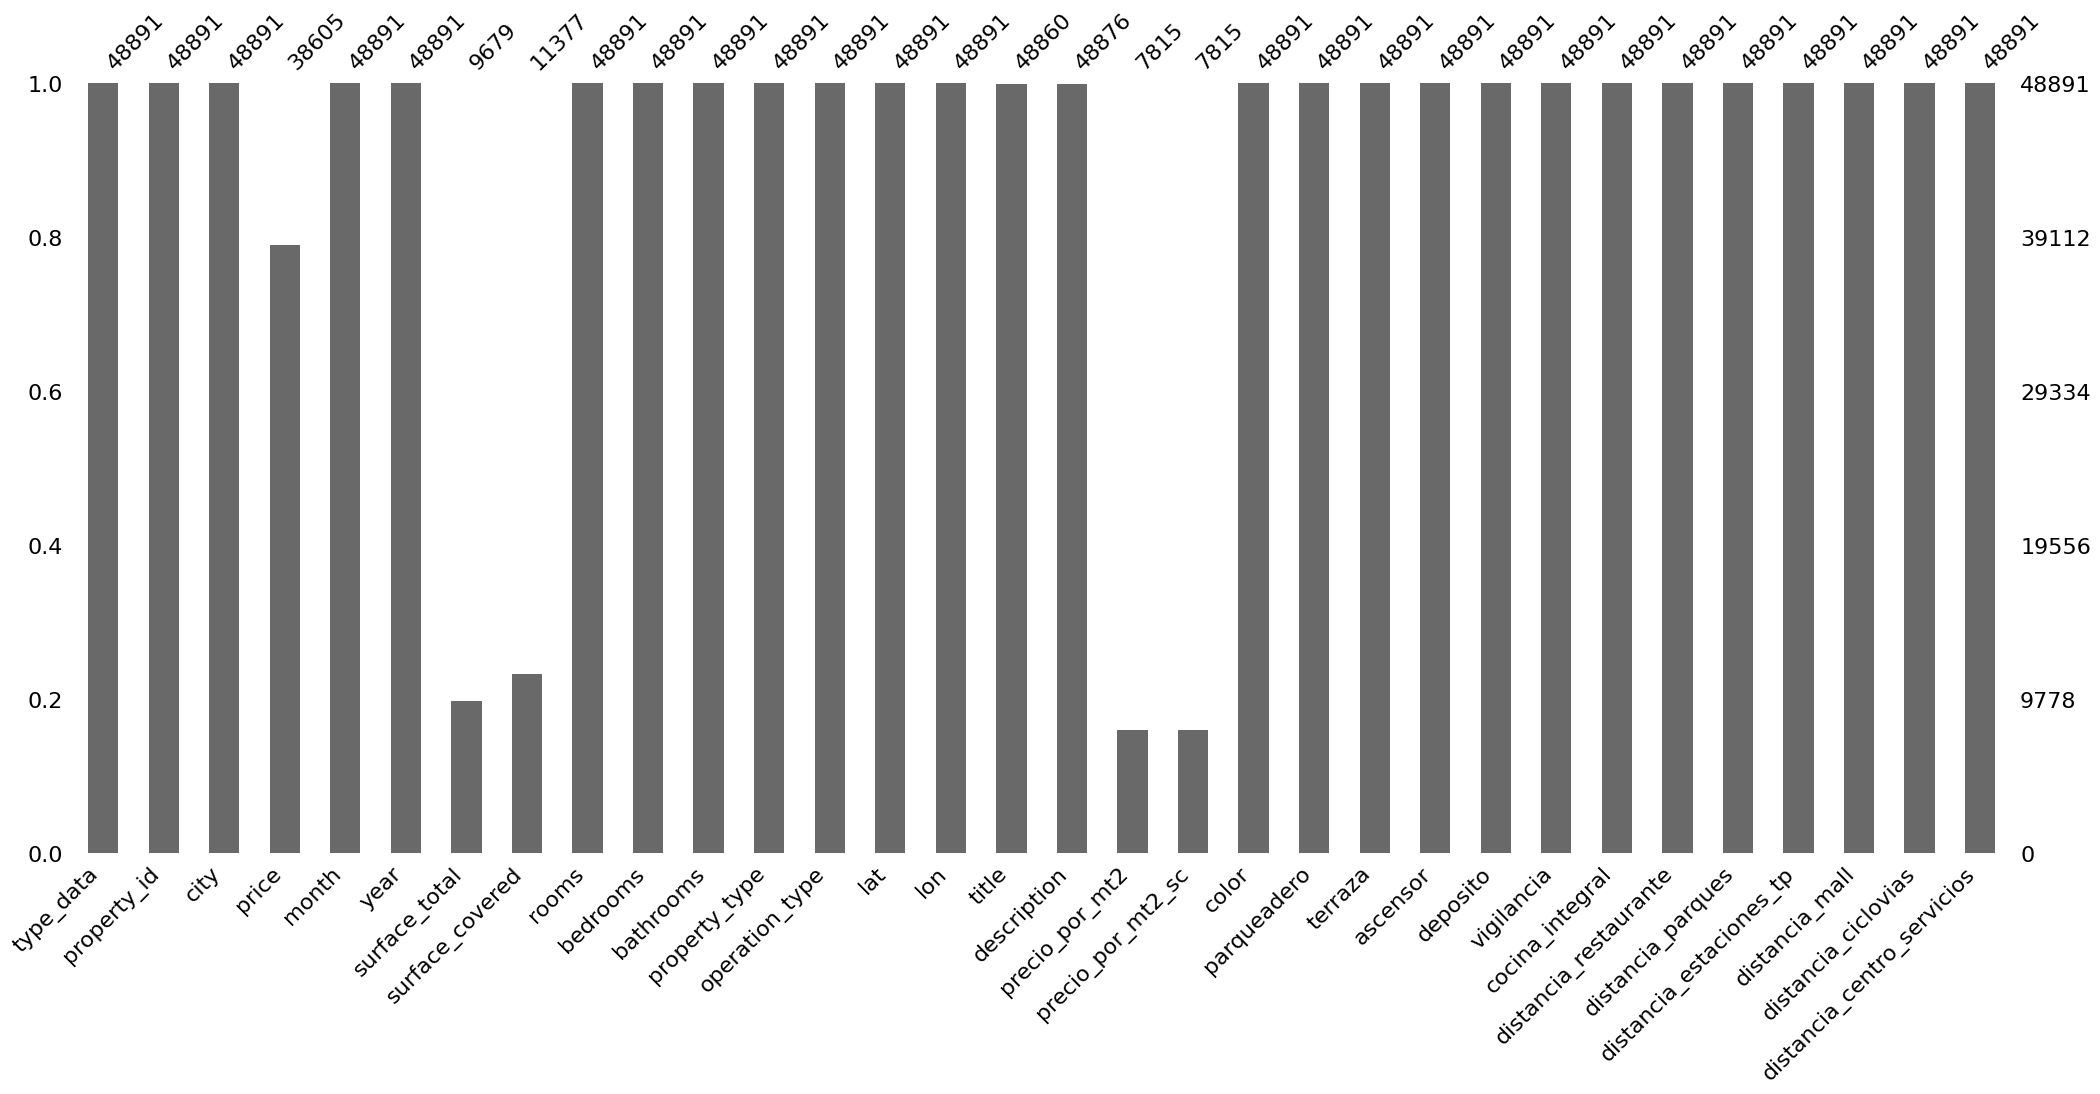

In [29]:
msno.bar(casas)

In [30]:
casas_knn = casas

In [31]:
#Quitamos las variables no numericas
casas_knn = casas_knn.select_dtypes(exclude = ['object'])
casas_knn = casas_knn.reset_index(drop = True)

El modelo de imputación por k-vecinos imputará todos los valores faltantes de la base que usemos. Para no afectar la variable objetivo del taller (price) se eliminará temporalmente. La variable objetivo de este modelo será rooms

In [32]:
#Comenzamos con un modelo sencillo
imputacion = KNNImputer(n_neighbors = 1, weights = 'distance')

In [33]:
casas_knn = casas_knn.drop(['price'], axis=1)
casas_knn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48891 entries, 0 to 48890
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   type_data                   48891 non-null  int64  
 1   month                       48891 non-null  int64  
 2   year                        48891 non-null  int64  
 3   surface_total               9679 non-null   float64
 4   surface_covered             11377 non-null  float64
 5   rooms                       48891 non-null  int64  
 6   bedrooms                    48891 non-null  int64  
 7   bathrooms                   48891 non-null  int64  
 8   lat                         48891 non-null  float64
 9   lon                         48891 non-null  float64
 10  precio_por_mt2              7815 non-null   float64
 11  precio_por_mt2_sc           7815 non-null   float64
 12  parqueadero                 48891 non-null  int64  
 13  terraza                     488

In [34]:
x = casas_knn.drop(columns = ['rooms'])
y = casas_knn['rooms']
# Dividimos la muestra
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 123)

# Normalizamos los datos
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [35]:
#Comenzamos con un modelo sencillo
imputacion = KNNImputer(n_neighbors = 1, weights = 'distance')

In [36]:
#Lo implementamos
x_train_imputed = imputacion.fit_transform(x_train)
x_test_imputed = imputacion.transform(x_test)

Vamos a calibrar el hiper parametro usando cross-validation

In [37]:
# Creamos un nuevo modelo
knn2 = KNeighborsRegressor()

# Creamos un rango de valores para probar
param_grid = {'n_neighbors': np.arange(1, 30)}

# Implementamos y luego hacemos fit
# Estamos haciendo un cross-validation de 200 grupos
knn_casas_grid = GridSearchCV(knn2, param_grid, cv = 200)
knn_casas_grid.fit(x_train_imputed, y_train)

#Hiperparametro
n_vecinos = knn_casas_grid.best_params_['n_neighbors']
#Acuracy
accuracy = knn_casas_grid.best_score_ * 100

#Interpretamos
print(f"El mejor número de vecinos es: {n_vecinos}")
print(f"Estamos prediciendo un {accuracy:.2f}% del número de cuartos.")

El mejor número de vecinos es: 10
Estamos prediciendo un 43.27% del número de cuartos.


In [38]:
imputacion = KNNImputer(n_neighbors = n_vecinos, weights = 'distance')

x_train_imputed = imputacion.fit_transform(x_train)
x_test_imputed = imputacion.transform(x_test)

Procedemos a consolidar la nueva base de datos

In [39]:
# Escalar los datos de vuelta a su forma original
x_train_original = scaler.inverse_transform(x_train_imputed)
x_test_original = scaler.inverse_transform(x_test_imputed)

In [40]:
#Convertimos los arrays predichos en dataframes
x_train_original_df = pd.DataFrame(x_train_original)

#Nombramos columnas
column_names = list(casas_knn.columns)
# Eliminamos rooms porque lo habiamos eliminado
column_names.pop(5)
x_train_original_df.columns = column_names

x_train_original_df.head()

,type_data,month,year,surface_total,surface_covered,bedrooms,bathrooms,lat,lon,precio_por_mt2,...,ascensor,deposito,vigilancia,cocina_integral,distancia_restaurante,distancia_parques,distancia_estaciones_tp,distancia_mall,distancia_ciclovias,distancia_centro_servicios
0,2.0,1.0,2021.0,123.590216,64.268127,1.0,2.0,4.642912,-74.056389,6.728964e+06,...,0.0,0.0,0.0,0.0,403.701342,357.754182,1133.853906,1594.120102,4262.315587,459.655508
1,1.0,5.0,2019.0,296.000000,243.487617,3.0,5.0,4.705000,-74.067001,3.614865e+06,...,0.0,0.0,0.0,1.0,760.363788,138.645082,572.952042,616.476395,145.681953,616.476395
2,2.0,4.0,2020.0,138.962135,116.837902,2.0,2.0,4.661403,-74.048739,8.012602e+06,...,0.0,0.0,0.0,0.0,389.564292,85.496721,792.537397,778.309272,4890.324038,954.955667
3,1.0,6.0,2021.0,81.585653,81.571116,3.0,3.0,4.719000,-74.043000,4.902276e+06,...,1.0,1.0,0.0,1.0,308.275624,190.349787,330.490422,405.690456,1963.925011,390.373952
4,1.0,1.0,2021.0,97.566639,159.000000,3.0,2.0,4.673000,-74.119000,4.983834e+06,...,1.0,1.0,0.0,1.0,513.964223,90.987175,1326.672895,362.832455,423.891386,204.371962


In [41]:
#Convertimos los arrays predichos en dataframes
x_test_original_df = pd.DataFrame(x_test_original)

#Nombramos columnas
column_names = list(casas_knn.columns)
# Eliminamos rooms porque lo habiamos eliminado
column_names.pop(5)
x_test_original_df.columns = column_names

x_test_original_df.head()


,type_data,month,year,surface_total,surface_covered,bedrooms,bathrooms,lat,lon,precio_por_mt2,...,ascensor,deposito,vigilancia,cocina_integral,distancia_restaurante,distancia_parques,distancia_estaciones_tp,distancia_mall,distancia_ciclovias,distancia_centro_servicios
0,1.0,8.0,2021.0,84.919859,90.518947,2.0,2.0,4.630255,-74.095690,5.905261e+06,...,1.0,0.0,0.0,0.0,275.917462,182.588587,1999.449151,881.844985,1181.497445,447.909900
1,1.0,11.0,2020.0,210.000000,210.000000,3.0,4.0,4.649000,-74.084000,7.142857e+06,...,1.0,0.0,1.0,1.0,450.718763,43.557619,314.912309,1229.742945,1225.589987,812.054675
2,1.0,12.0,2020.0,89.124223,89.124223,3.0,2.0,4.722740,-74.035160,5.109933e+06,...,1.0,1.0,0.0,1.0,172.830779,151.643319,665.742452,356.111175,1861.046075,365.030548
3,1.0,8.0,2020.0,99.753687,98.639264,3.0,2.0,4.724990,-74.047970,5.816964e+06,...,0.0,1.0,0.0,0.0,177.779857,50.920749,886.176140,476.899283,1133.155305,566.882015
4,1.0,5.0,2019.0,232.000000,161.802397,3.0,3.0,4.627000,-74.130997,2.586207e+06,...,0.0,1.0,0.0,0.0,26.980896,403.940847,1127.464069,1030.949826,3216.432899,1524.047374


In [42]:
#Unimos las bases de train y test
data = pd.concat([x_train_original_df, x_test_original_df])

Solo vamos a dejar las variables imputadas que tenian missing values para unirlas a la base original

In [43]:
columnas_para_unir = ['surface_total', 'surface_covered', 'precio_por_mt2', 'precio_por_mt2_sc']

data = data[columnas_para_unir]
renombrar_columnas = {
    'surface_total': 'surface_total_kv',
    'surface_covered': 'surface_covered_kv',
    'precio_por_mt2': 'precio_por_mt2_kn',
    'precio_por_mt2_sc': 'precio_por_mt2_sc_kv',
}
data = data.rename(columns = renombrar_columnas)
data.head()

,surface_total_kv,surface_covered_kv,precio_por_mt2_kn,precio_por_mt2_sc_kv
0,123.590216,64.268127,6.728964e+06,0.417806
1,296.000000,243.487617,3.614865e+06,0.190214
2,138.962135,116.837902,8.012602e+06,0.511620
3,81.585653,81.571116,4.902276e+06,0.284304
4,97.566639,159.000000,4.983834e+06,0.290264


In [44]:
#Unimos las variables imputadas a la base original
casas_con_data = casas.merge(data, left_index = True, right_index = True, how = 'left')

In [45]:
#Revisamos missing values en la nueva base
casas_con_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58670 entries, 0 to 48890
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   type_data                   58670 non-null  int64  
 1   property_id                 58670 non-null  object 
 2   city                        58670 non-null  object 
 3   price                       48384 non-null  float64
 4   month                       58670 non-null  int64  
 5   year                        58670 non-null  int64  
 6   surface_total               10359 non-null  float64
 7   surface_covered             12819 non-null  float64
 8   rooms                       58670 non-null  int64  
 9   bedrooms                    58670 non-null  int64  
 10  bathrooms                   58670 non-null  int64  
 11  property_type               58670 non-null  object 
 12  operation_type              58670 non-null  object 
 13  lat                         58670 no

In [46]:
casas_con_data.head(30)

,type_data,property_id,city,price,month,year,surface_total,surface_covered,rooms,bedrooms,...,distancia_restaurante,distancia_parques,distancia_estaciones_tp,distancia_mall,distancia_ciclovias,distancia_centro_servicios,surface_total_kv,surface_covered_kv,precio_por_mt2_kn,precio_por_mt2_sc_kv
0,1,4fa04a187235d7509a43a8cf,Bogotá D.C,5.800000e+08,10,2020,NaN,NaN,3,3,...,154.235265,231.089150,1766.961653,495.193141,1832.908735,1453.693500,123.590216,64.268127,6.728964e+06,0.417806
0,1,4fa04a187235d7509a43a8cf,Bogotá D.C,5.800000e+08,10,2020,NaN,NaN,3,3,...,154.235265,231.089150,1766.961653,495.193141,1832.908735,1453.693500,84.919859,90.518947,5.905261e+06,0.357606
1,1,f9cfbb306af543a759c1f3f2,Bogotá D.C,6.000000e+08,10,2020,NaN,NaN,9,9,...,241.721101,50.341416,2380.221077,841.474317,4099.793278,1978.803065,296.000000,243.487617,3.614865e+06,0.190214
1,1,f9cfbb306af543a759c1f3f2,Bogotá D.C,6.000000e+08,10,2020,NaN,NaN,9,9,...,241.721101,50.341416,2380.221077,841.474317,4099.793278,1978.803065,210.000000,210.000000,7.142857e+06,0.448055
2,1,957a84e8e93ae2b33bc6f61b,Bogotá D.C,4.000000e+08,10,2020,NaN,NaN,8,8,...,280.253026,168.366002,3598.155341,721.655341,3831.696986,1013.837460,138.962135,116.837902,8.012602e+06,0.511620
2,1,957a84e8e93ae2b33bc6f61b,Bogotá D.C,4.000000e+08,10,2020,NaN,NaN,8,8,...,280.253026,168.366002,3598.155341,721.655341,3831.696986,1013.837460,89.124223,89.124223,5.109933e+06,0.299480
3,1,eb32d75b32bc5e8677207fc7,Bogotá D.C,8.000000e+08,10,2020,NaN,NaN,6,6,...,208.582807,407.701140,3955.638932,451.149357,1492.445775,490.970545,81.585653,81.571116,4.902276e+06,0.284304
3,1,eb32d75b32bc5e8677207fc7,Bogotá D.C,8.000000e+08,10,2020,NaN,NaN,6,6,...,208.582807,407.701140,3955.638932,451.149357,1492.445775,490.970545,99.753687,98.639264,5.816964e+06,0.351153
4,1,880a6e7bd74dc2568940d275,Bogotá D.C,4.800000e+08,10,2020,NaN,NaN,3,3,...,11.600085,162.969700,3304.065598,429.654825,2696.154786,72.614360,97.566639,159.000000,4.983834e+06,0.290264
4,1,880a6e7bd74dc2568940d275,Bogotá D.C,4.800000e+08,10,2020,NaN,NaN,3,3,...,11.600085,162.969700,3304.065598,429.654825,2696.154786,72.614360,232.000000,161.802397,2.586207e+06,0.115036


In [47]:
#Guardamos la base
ruta = '/workspaces/Problem_set2_BDML/stores/base_imputada_kvecinos.csv'
casas_con_data.to_csv('base_datos_kvecinos.csv', index = False)